Importação das bibliotecas **necessárias**


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.datasets import fetch_rcv1
from sklearn.decomposition import PCA
from sklearn.metrics import (precision_score, recall_score, f1_score, hamming_loss,
                             multilabel_confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Classe auxiliar: LearningRateFinder

Essa classe ajuda a encontrar a melhor taxa de aprendizado ("learning rate")

In [2]:
# A LearningRateFinder é uma Callback personalizada do Keras que realiza o seguinte:

# Treina o modelo por algumas iterações (batches),
# Aumenta exponencialmente a taxa de aprendizado a cada batch,
# Registra a perda (loss) correspondente a cada taxa de aprendizado,
# E no final, plota um gráfico da perda em função da taxa de aprendizado para ajudar a escolher uma boa learning_rate.

class LearningRateFinder(tf.keras.callbacks.Callback):
    def __init__(self, start_lr=1e-7, end_lr=10, num_iter=100):
        super().__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_iter = num_iter
        self.lrs = []
        self.losses = []
        self.best_loss = 1e9


    def on_train_begin(self, logs=None):
      # Executa no início do treinamento.
      # Define a taxa de aprendizado inicial manualmente.
      # Cria a variável step para acompanhar o progresso.
        self.step = 0
        if not isinstance(self.model.optimizer.learning_rate, tf.Variable):
            self.model.optimizer.learning_rate = tf.Variable(self.start_lr, dtype=tf.float32)
        self.model.optimizer.learning_rate.assign(self.start_lr)

    def on_batch_end(self, batch, logs=None):
      # Executa ao final de cada batch.
      # Coleta a perda (loss) atual e a taxa de aprendizado.
      # Verifica se a perda piorou demais (loss > best_loss * 10) → se sim, interrompe o treinamento.
      # Atualiza a melhor perda observada.
      # Aumenta a learning_rate em escala logarítmica.
      # 🔁 Isso se repete até atingir num_iter batches.
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        loss = logs["loss"]
        self.lrs.append(lr)
        self.losses.append(loss)
        self.step += 1

        # Interrompe o treinamento se o loss piorar muito
        if self.step > self.num_iter or loss > self.best_loss * 10:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Atualiza a taxa de aprendizado em escala logarítmica
        new_lr = lr * (self.end_lr / self.start_lr) ** (1 / self.num_iter)
        self.model.optimizer.learning_rate.assign(new_lr)

    def plot(self):
        # Gera um gráfico com:
        # Eixo X (logarítmico): taxas de aprendizado testadas.
        # Eixo Y: perda (loss) correspondente.
        # Ajuda a escolher um bom valor de learning rate.
        plt.figure(figsize=(8,6))
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate (log scale)')
        plt.ylabel('Loss')
        plt.title('Learning Rate Finder')
        plt.grid(True)
        plt.show()

Classe Principal: MultilabelClassificationPipeline

In [3]:
# Essa classe foi criada para organizar e automatizar o processo de classificação multirrótulo (multilabel classification).

# Ela encapsula o pré-processamento dos dados e prepara tudo o que é necessário para treinar um modelo de classificação multirrótulo com Keras/TensorFlow.

class MultilabelClassificationPipeline:
    def __init__(self, X, Y, test_size=0.2, random_state=42):
         # Divide os dados em treino e validação
        self.X_train_raw, self.X_val_raw, self.Y_train, self.Y_val = train_test_split(
            X, Y, test_size=test_size, random_state=random_state)

        # Aplica normalização (z-score)
        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(self.X_train_raw)
        self.X_val = self.scaler.transform(self.X_val_raw)

        self.num_features = self.X_train.shape[1]
        self.num_classes = self.Y_train.shape[1]
        self.history = {}

Métricas de Avaliação

In [4]:
# Essa função calcula métricas de avaliação específicas para classificação multirrótulo:

# Entrada:

#   y_true: matriz com os rótulos verdadeiros (ex: [0, 1, 0, 1]).
#   y_pred: probabilidades previstas pelo modelo (ex: [0.2, 0.8, 0.4, 0.9]).
#   threshold: limiar para converter probabilidades em 0 ou 1 (default = 0.5).

# Conversão para binário:
#   Aqui, cada probabilidade maior que o threshold vira 1, o resto vira 0.

# Cálculo das métricas:

#   precision_score: quão precisas são as predições (quantos dos rótulos previstos estavam certos).
#   recall_score: quantos dos rótulos verdadeiros o modelo conseguiu recuperar.
#   f1_score: média harmônica entre precisão e recall.
#   hamming_loss: fração das etiquetas incorretas (menor = melhor).


def multilabel_metrics(self, y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(int)
    precision = precision_score(y_true, y_pred_bin, average='samples', zero_division=0)
    recall = recall_score(y_true, y_pred_bin, average='samples', zero_division=0)
    f1 = f1_score(y_true, y_pred_bin, average='samples', zero_division=0)
    hamming = hamming_loss(y_true, y_pred_bin)
    return precision, recall, f1, hamming


# Essa função imprime a matriz de confusão individual para cada classe.

# Entrada:

#   y_true: rótulos verdadeiros.
#   y_pred: predições do modelo (probabilidades).
#   threshold: limiar para decidir se uma classe foi prevista (1) ou não (0).
#   class_names: lista com nomes legíveis das classes (opcional).

# Conversão para binário:
#   Igual à função anterior, transforma probabilidades em 0/1.

# Geração da matriz de confusão multirrótulo:
#   Isso retorna uma matriz por classe com os valores:
#   TP (True Positive)
#   FP (False Positive)
#   FN (False Negative)
#   TN (True Negative)

# Impressão dos resultados por classe:
#   O ravel() desfaz a matriz 2x2 para 4 valores simples (TN, FP, FN, TP), e o loop imprime por classe.



def print_multilabel_confusion(self, y_true, y_pred, threshold=0.5, class_names=None):
    y_pred_bin = (y_pred > threshold).astype(int)
    cm = multilabel_confusion_matrix(y_true, y_pred_bin)
    print("Matriz de Confusão por Classe:")
    for i, matrix in enumerate(cm):
        tn, fp, fn, tp = matrix.ravel()
        cname = f"Classe {i}" if class_names is None else class_names[i]
        print(f"{cname}: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

**Arquiteturas de Modelos**

Modelo Base Simples

In [5]:
# Essa função constrói e retorna um modelo de rede neural simples para classificação multirrótulo.

# Entrada da rede
#   Define a camada de entrada do modelo.
#   input_dim é o número de features do seu vetor de entrada (ex: 1000 se for TF-IDF com 1000 palavras).
#   Espera um vetor unidimensional com esse tamanho para cada exemplo.

# Camada oculta
#   Cria uma camada densa (fully connected) com 512 neurônios.
#   Usa a função de ativação ReLU, que é muito comum para camadas ocultas porque ajuda no aprendizado sem saturar.

# Camada de saída
#   A saída é outra camada densa, com output_dim neurônios.
#   output_dim representa o número de classes ou rótulos que podem estar presentes em cada exemplo.
#   A ativação é sigmoid, que retorna um valor entre 0 e 1 por rótulo — ideal para multirrótulo (diferente de softmax, que é para multiclasse).

def build_model_base(self, input_dim, output_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(512, activation='relu')(inputs)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=outputs, name="Modelo_Base")
    return model

Modelo com Blocos: Normalização e Dropout

In [6]:
# Essa função constrói uma rede neural com dois blocos densos, cada um seguido de normalização em batch e dropout, que ajudam a melhorar a estabilidade e a generalização do modelo.

# Entrada
#   Entrada da rede, com input_dim dimensões (quantidade de features).

# Primeiro bloco denso
#   Dense(512): camada totalmente conectada com 512 neurônios e ativação ReLU.
#   BatchNormalization(): normaliza a saída do Dense — isso acelera o treinamento e reduz oscilação na atualização dos pesos.
#   Dropout(0.3): desativa aleatoriamente 30% dos neurônios durante o treino, para evitar overfitting.

# Segundo bloco denso
#   Mesmo padrão do bloco anterior, mas com 256 neurônios.
#   Nome dado à camada: 'intermediate_layer' — útil se você quiser extrair representações intermediárias do modelo (ex: para embeddings).

# Saída
#   Camada final com output_dim neurônios (um para cada rótulo).

#   Ativação sigmoid, pois estamos lidando com classificação multirrótulo (cada saída é independente e pode ser ativada ou não).

def build_model_base_blocos(self, input_dim, output_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(512, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu', name='intermediate_layer')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=outputs, name="Modelo_Base_Blocos")
    return model

Modelo Customizado com Focal Loss

In [7]:
# Essa função constrói uma rede semelhante à anterior (build_model_base_blocos), mas com uma perda customizada chamada Focal Loss, além de incluir métricas como precisão e recall durante o treinamento.

# Função interna focal_loss -> focal_loss_fixed
#   Cria uma função de perda customizada parametrizável (gamma, alpha).
#   Retorna a função real usada pelo model.compile().
  # Evita log(0) e divisões por zero ao forçar o valor de y_pred ficar entre (ε, 1−ε).
  # Calcula a entropia cruzada binária padrão.
  # Aplica o fator de focalização: dá mais peso a erros (previsões distantes do alvo).

def build_model_custom(self, input_dim, output_dim):
    def focal_loss(gamma=2., alpha=.25):
        def focal_loss_fixed(y_true, y_pred):
            epsilon = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
            cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
            weight = alpha * y_true * tf.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * tf.pow(y_pred, gamma)
            loss = weight * cross_entropy
            return tf.reduce_mean(loss, axis=-1)
        return focal_loss_fixed

    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(512, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu', name='intermediate_layer')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=outputs, name="Modelo_Customizado")
    model.compile(optimizer='adam',
                  loss=focal_loss(gamma=2., alpha=0.25),
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

**Funções de Treinamento e Avaliação**

In [8]:
# Essa função executa o Learning Rate Finder para descobrir a melhor taxa de aprendizado para o otimizador.

# Assim podemos:
# Treinar o modelo por poucas iterações,
# Aumentando a taxa de aprendizado exponencialmente a cada passo,
# Anotar a perda (loss) em cada ponto,
# Plotar a curva da perda vs. taxa de aprendizado.

def find_best_lr(self, model, X_train_data, Y_train_data, epochs=1, batch_size=64):
    print("\nIniciando Learning Rate Finder...")
    lr_finder = LearningRateFinder(start_lr=1e-6, end_lr=1, num_iter=50)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr_finder.start_lr),
                  loss='binary_crossentropy')
    model.fit(X_train_data, Y_train_data,
              batch_size=batch_size,
              epochs=epochs,
              callbacks=[lr_finder],
              verbose=0)
    lr_finder.plot()
    print("📉 Dica: Observe o gráfico da perda. A taxa de aprendizado ideal está na região onde a perda diminui rapidamente, mas ainda não começa a subir. Evite taxas muito altas que causam instabilidade.")


# Função de treinamento:

# Recebe o modelo, os dados e parâmetros como epochs, batch_size, etc.

# Usa callbacks importantes:
# EarlyStopping: para parar automaticamente se o modelo parar de melhorar.
# ReduceLROnPlateau: reduz a taxa de aprendizado se a performance estagnar.

# Por fim armazena o histórico de treinamento no dicionário self.history.

def train(self, model, X_train_data, Y_train_data, X_val_data, Y_val_data, epochs=10, batch_size=64, learning_rate=None):
    print(f"\nTreinando {model.name}...")

    if learning_rate:
        tf.keras.backend.set_value(model.optimizer.learning_rate, learning_rate)
        print(f"Taxa de aprendizado definida para: {learning_rate}")

    # Callbacks para otimização do treinamento
    callbacks_list = [
        callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
    ]

    history = model.fit(X_train_data, Y_train_data,
                        validation_data=(X_val_data, Y_val_data),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=callbacks_list,
                        verbose=2)
    self.history[model.name] = history
    return history


# Usa o modelo para prever y_pred.

# Aplica self.multilabel_metrics com um threshold de 0.5.
# Retorna as métricas: precisão, recall, f1 e hamming loss.
def evaluate(self, model, X_val_data, Y_val_data, threshold=0.5):
    y_pred = model.predict(X_val_data)
    return self.multilabel_metrics(Y_val_data, y_pred, threshold), y_pred



# Essa função mostra como as métricas variam ao alterar o threshold (de 0.1 a 0.9)
def evaluate_thresholds(self, y_true, y_pred_probs):
    thresholds = np.linspace(0.1, 0.9, 9)
    print("\nAvaliando métricas para diferentes thresholds:")
    for t in thresholds:
        precision = precision_score(y_true, y_pred_probs > t, average='samples', zero_division=0)
        recall = recall_score(y_true, y_pred_probs > t, average='samples', zero_division=0)
        f1 = f1_score(y_true, y_pred_probs > t, average='samples', zero_division=0)
        print(f"Threshold={t:.2f}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")


# Extrai saídas de uma camada intermediária do modelo (camada oculta de 256 neurônios).
def demo_hook(self, model, X_val_data):
    print("\nExtraindo saídas intermediárias com hooks (camada densa 256)...")
    if 'intermediate_layer' in [layer.name for layer in model.layers]:
        intermediate_layer_model = models.Model(inputs=model.input,
                                                outputs=model.get_layer('intermediate_layer').output)
        intermediate_output = intermediate_layer_model.predict(X_val_data[:5])
        print(f"Saída intermediária shape: {intermediate_output.shape}")
    else:
        print("Camada 'intermediate_layer' não encontrada neste modelo.")



**Visualizações**

In [9]:
# O método plot_loss_accuracy gera gráficos de perda (loss) e acurácia (accuracy) ao longo das épocas de treinamento de cada modelo.

# Funcionamento:
# Para cada modelo treinado, ele extrai o objeto history gerado pelo model.fit().

# Em seguida, plota dois gráficos:
# Loss: compara a perda no conjunto de treino vs validação.
# Accuracy: compara a acurácia no treino vs validação.

# Esse acompanhamento visual ajuda a detectar:
# Overfitting (quando a validação piora enquanto o treino melhora).
def plot_loss_accuracy(self):

    for model_name, data in self.history.items():
        history = data['history']

        plt.figure(figsize=(12,5))

        # Loss
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='Treino')
        plt.plot(history.history['val_loss'], label='Validação')
        plt.title(f'{model_name} - Loss')
        plt.xlabel('Épocas')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy
        plt.subplot(1,2,2)
        plt.plot(history.history.get('accuracy', []), label='Treino')
        plt.plot(history.history.get('val_accuracy', []), label='Validação')
        plt.title(f'{model_name} - Accuracy')
        plt.xlabel('Épocas')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()


# O método plot_confusion_matrices gera as matrizes de confusão binárias para cada classe individual, usando a função multilabel_confusion_matrix do sklearn.

# Funcionamento:
# Para cada modelo treinado:
# Faz a predição sobre o conjunto de validação.
# Converte os scores para 0 ou 1 com um threshold (por padrão 0.5).
# Gera uma matriz 2x2 para cada rótulo (classe).

# As matrizes mostram:
# Verdadeiros Positivos (TP)
# Falsos Positivos (FP)
# Verdadeiros Negativos (TN)
# Falsos Negativos (FN)

# Usa seaborn.heatmap para visualização clara e colorida.

# Permite passar nomes de classes via class_names.

# Interpretação:
# Esse tipo de análise é essencial para entender como o modelo se comporta individualmente em cada rótulo.

def plot_confusion_matrices(self, threshold=0.5, class_names=None):
    for model_name, data in self.history.items():
        model = data['model']
        X_val = data['X_val']
        Y_val = data['Y_val']

        y_pred = model.predict(X_val)
        y_pred_bin = (y_pred > threshold).astype(int)
        cms = multilabel_confusion_matrix(Y_val, y_pred_bin)
        n_classes = cms.shape[0]

        print(f"\nMatrizes de Confusão - {model_name}")

        fig, axes = plt.subplots(nrows=int(np.ceil(n_classes/5)), ncols=5,
                                figsize=(20, 3*int(np.ceil(n_classes/5))))
        axes = axes.flatten()

        for i in range(n_classes):
            cm = cms[i]
            sns.heatmap(cm, annot=True, fmt='d', cbar=False, ax=axes[i],
                        xticklabels=['Neg Pred', 'Pos Pred'], yticklabels=['Neg True', 'Pos True'])
            cname = f'Classe {i}' if class_names is None else class_names[i]
            axes[i].set_title(cname)

        for j in range(n_classes, len(axes)):
            fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()


# O método compare_metrics calcula e compara métricas globais de avaliação dos modelos em múltiplos thresholds.

# Métricas utilizadas:
# Precision (Precisão): % de rótulos positivos corretamente previstos.
# Recall (Revocação): % de rótulos reais positivos que foram capturados.
# F1-Score: Harmônica entre precision e recall.
# Hamming Loss: Proporção de rótulos incorretos (quanto menor, melhor).

# Funcionamento:
# Para cada modelo e cada valor de threshold (ex: 0.3, 0.5, 0.7...):
# Realiza a predição.
# Calcula todas as métricas citadas.
# Organiza os resultados em um DataFrame.
# Gera gráficos de barras comparativos para cada métrica.

# Vantagens:
# Permite identificar:
# Qual modelo teve melhor equilíbrio entre precision e recall.
# Como o desempenho muda com diferentes thresholds.
# Quais modelos erram mais ou menos (hamming loss).

def compare_metrics(self, thresholds=[0.5]):
    metrics_data = []

    for model_name, data in self.history.items():
        model = data['model']
        X_val = data['X_val']
        Y_val = data['Y_val']
        y_pred = model.predict(X_val)
        for t in thresholds:
            precision = precision_score(Y_val, y_pred > t, average='samples', zero_division=0)
            recall = recall_score(Y_val, y_pred > t, average='samples', zero_division=0)
            f1 = f1_score(Y_val, y_pred > t, average='samples', zero_division=0)
            hamming = hamming_loss(Y_val, y_pred > t)
            metrics_data.append({
                'Modelo': model_name,
                'Threshold': t,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Hamming Loss': hamming
            })

    df = pd.DataFrame(metrics_data)

    for metric in ['Precision', 'Recall', 'F1', 'Hamming Loss']:
        plt.figure(figsize=(10,6))
        sns.barplot(data=df, x='Modelo', y=metric, hue='Threshold')
        plt.title(f'Comparação de {metric} por Modelo e Threshold')
        plt.ylabel(metric)
        plt.xlabel('Modelo')
        plt.xticks(rotation=45)
        plt.legend(title='Threshold')
        plt.grid(True)
        plt.show()

** Execução do pipeline **

In [ ]:
def run_all(self):
        print("Rodando pipeline completa")

        # --- Modelo Base ---
        # Compila com binary_crossentropy.
        # Usa find_best_lr() e treina com taxa ajustada.
        # Avalia o desempenho (métricas e matrizes de confusão).
        model_base = self.build_model_base(self.num_features, self.num_classes)
        model_base.compile(optimizer='adam', loss='binary_crossentropy',
                           metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        self.find_best_lr(model_base, self.X_train, self.Y_train)
        best_lr_for_base = 0.001
        model_base.compile(optimizer=optimizers.Adam(learning_rate=best_lr_for_base),
                           loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        history_base = self.train(model_base, self.X_train, self.Y_train, self.X_val, self.Y_val, epochs=25)
        metrics_base, y_pred_base = self.evaluate(model_base, self.X_val, self.Y_val)
        print(f"Métricas Modelo Base: Precision={metrics_base[0]:.4f}, Recall={metrics_base[1]:.4f}, F1={metrics_base[2]:.4f}, Hamming Loss={metrics_base[3]:.4f}")

        # --- Modelo Base + PCA ---
        # Reduz dimensionalidade com PCA.
        # Treina o mesmo modelo base com menos features.
        # Compara se a redução de dimensionalidade afeta a performance.
        print("\nAplicando PCA (com dados já escalados)...")
        pca = PCA(n_components=512)
        X_train_pca = pca.fit_transform(self.X_train)
        X_val_pca = pca.transform(self.X_val)

        model_base_pca = self.build_model_base(512, self.num_classes)
        model_base_pca.compile(optimizer='adam', loss='binary_crossentropy',
                               metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        self.find_best_lr(model_base_pca, X_train_pca, self.Y_train)
        best_lr_for_pca = 0.001
        model_base_pca.compile(optimizer=optimizers.Adam(learning_rate=best_lr_for_pca),
                               loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        history_pca = self.train(model_base_pca, X_train_pca, self.Y_train, X_val_pca, self.Y_val, epochs=25)
        metrics_pca, y_pred_pca = self.evaluate(model_base_pca, X_val_pca, self.Y_val)
        print(f"Métricas Modelo Base + PCA: Precision={metrics_pca[0]:.4f}, Recall={metrics_pca[1]:.4f}, F1={metrics_pca[2]:.4f}, Hamming Loss={metrics_pca[3]:.4f}")

        # --- Modelo Base + Blocos ---
        # Adiciona BatchNormalization e Dropout.
        # Melhorar a generalização e estabilizar o treinamento.
        # Avalia da mesma forma que os anteriores.
        model_blocos = self.build_model_base_blocos(self.num_features, self.num_classes)
        model_blocos.compile(optimizer='adam', loss='binary_crossentropy',
                            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        self.find_best_lr(model_blocos, self.X_train, self.Y_train)
        best_lr_for_blocos = 0.001
        model_blocos.compile(optimizer=optimizers.Adam(learning_rate=best_lr_for_blocos),
                            loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        history_blocos = self.train(model_blocos, self.X_train, self.Y_train, self.X_val, self.Y_val, epochs=25)
        metrics_blocos, y_pred_blocos = self.evaluate(model_blocos, self.X_val, self.Y_val)
        print(f"Métricas Modelo Base + Blocos: Precision={metrics_blocos[0]:.4f}, Recall={metrics_blocos[1]:.4f}, F1={metrics_blocos[2]:.4f}, Hamming Loss={metrics_blocos[3]:.4f}")

        # --- Modelo Customizado (Focal Loss) ---
        # Usa Focal Loss para tratar desbalanceamento de classes.
        # Um modelo temporário (temp_model_for_lr_finder) é criado apenas para find_best_lr().
        # Treina com a melhor taxa de aprendizado estimada.
        # Avalia, gera métricas, thresholds, matriz de confusão e ativa o demo_hook.
        model_custom = self.build_model_custom(self.num_features, self.num_classes)
        print("\nExecutando Learning Rate Finder para Modelo Customizado (Focal Loss)...")
        temp_model_for_lr_finder = self.build_model_base_blocos(self.num_features, self.num_classes)
        temp_model_for_lr_finder.compile(optimizer='adam', loss='binary_crossentropy')
        self.find_best_lr(temp_model_for_lr_finder, self.X_train, self.Y_train)
        best_lr_for_custom = 0.001
        print(f"\nTreinando Modelo Customizado (Focal Loss) com LR {best_lr_for_custom}...")
        model_custom.compile(optimizer=optimizers.Adam(learning_rate=best_lr_for_custom),
                             loss=model_custom.loss,
                             metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        history_custom = self.train(model_custom, self.X_train, self.Y_train, self.X_val, self.Y_val, epochs=25)
        metrics_custom, y_pred_custom = self.evaluate(model_custom, self.X_val, self.Y_val)
        print(f"Métricas Modelo Customizado: Precision={metrics_custom[0]:.4f}, Recall={metrics_custom[1]:.4f}, F1={metrics_custom[2]:.4f}, Hamming Loss={metrics_custom[3]:.4f}")

        self.demo_hook(model_custom, self.X_val)

        # Salva todos os histories no dicionário
        # Após treinar o modelo base:
        self.history[model_base.name] = {'history': history_base, 'model': model_base, 'X_val': self.X_val, 'Y_val': self.Y_val}
        # Após treinar o modelo PCA:
        self.history[model_base_pca.name] = {'history': history_pca, 'model': model_base_pca, 'X_val': X_val_pca, 'Y_val': self.Y_val}
        # Após treinar o modelo blocos:
        self.history[model_blocos.name] = {'history': history_blocos, 'model': model_blocos, 'X_val': self.X_val, 'Y_val': self.Y_val}
        # Após treinar o modelo custom:
        self.history[model_custom.name] = {'history': history_custom, 'model': model_custom, 'X_val': self.X_val, 'Y_val': self.Y_val}

        # Gera as visualizações automaticamente
        self.plot_loss_accuracy()
        self.plot_confusion_matrices()
        self.compare_metrics(thresholds=[0.3, 0.5, 0.7])


if __name__ == "__main__":
    print("Carregando dados RCV1...")
    rcv1 = fetch_rcv1(shuffle=True, download_if_missing=True)
    X = rcv1.data[:1000].toarray().astype(np.float32)
    Y = rcv1.target[:1000].toarray().astype(np.float32)

    pipeline = MultilabelClassificationPipeline(X, Y)
    pipeline.run_all()

**Notebook completo para execução única**

Carregando dados RCV1...
Rodando pipeline completa

Iniciando Learning Rate Finder...


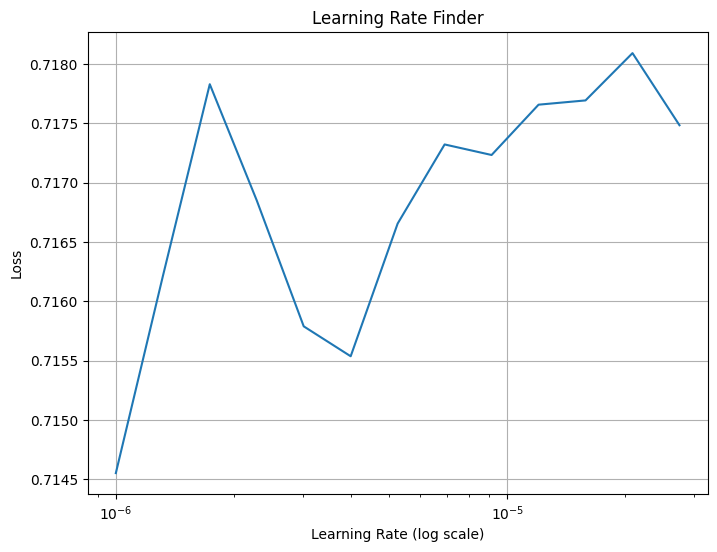

📉 A taxa de aprendizado ideal está na região onde a perda diminui rapidamente, mas ainda não começa a subir.

Treinando Modelo_Base...
Epoch 1/25
13/13 - 9s - 701ms/step - accuracy: 0.0562 - loss: 0.4870 - precision_17: 0.0583 - recall_17: 0.3804 - val_accuracy: 0.1250 - val_loss: 0.1582 - val_precision_17: 0.4405 - val_recall_17: 0.3096 - learning_rate: 1.0000e-03
Epoch 2/25
13/13 - 17s - 1s/step - accuracy: 0.2763 - loss: 0.0688 - precision_17: 0.8804 - recall_17: 0.5652 - val_accuracy: 0.2550 - val_loss: 0.1027 - val_precision_17: 0.7653 - val_recall_17: 0.4443 - learning_rate: 1.0000e-03
Epoch 3/25
13/13 - 13s - 989ms/step - accuracy: 0.3762 - loss: 0.0178 - precision_17: 0.9884 - recall_17: 0.8872 - val_accuracy: 0.2400 - val_loss: 0.0850 - val_precision_17: 0.7815 - val_recall_17: 0.4706 - learning_rate: 1.0000e-03
Epoch 4/25
13/13 - 9s - 705ms/step - accuracy: 0.3438 - loss: 0.0044 - precision_17: 0.9980 - recall_17: 0.9804 - val_accuracy: 0.2300 - val_loss: 0.0807 - val_precisi

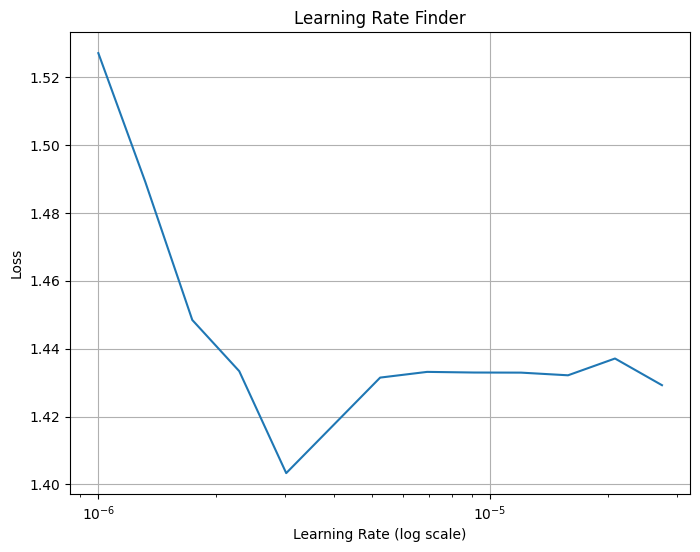

📉 A taxa de aprendizado ideal está na região onde a perda diminui rapidamente, mas ainda não começa a subir.

Treinando Modelo_Base...
Epoch 1/25
13/13 - 2s - 160ms/step - accuracy: 0.0325 - loss: 0.5536 - precision_19: 0.0421 - recall_19: 0.2300 - val_accuracy: 0.1400 - val_loss: 0.1880 - val_precision_19: 0.4745 - val_recall_19: 0.1440 - learning_rate: 1.0000e-03
Epoch 2/25
13/13 - 1s - 66ms/step - accuracy: 0.1838 - loss: 0.1407 - precision_19: 0.6667 - recall_19: 0.2288 - val_accuracy: 0.1750 - val_loss: 0.1311 - val_precision_19: 0.6167 - val_recall_19: 0.2740 - learning_rate: 1.0000e-03
Epoch 3/25
13/13 - 0s - 19ms/step - accuracy: 0.2537 - loss: 0.0852 - precision_19: 0.8999 - recall_19: 0.4280 - val_accuracy: 0.2500 - val_loss: 0.1217 - val_precision_19: 0.6148 - val_recall_19: 0.3854 - learning_rate: 1.0000e-03
Epoch 4/25
13/13 - 0s - 21ms/step - accuracy: 0.3050 - loss: 0.0477 - precision_19: 0.9722 - recall_19: 0.6576 - val_accuracy: 0.2500 - val_loss: 0.1181 - val_precision

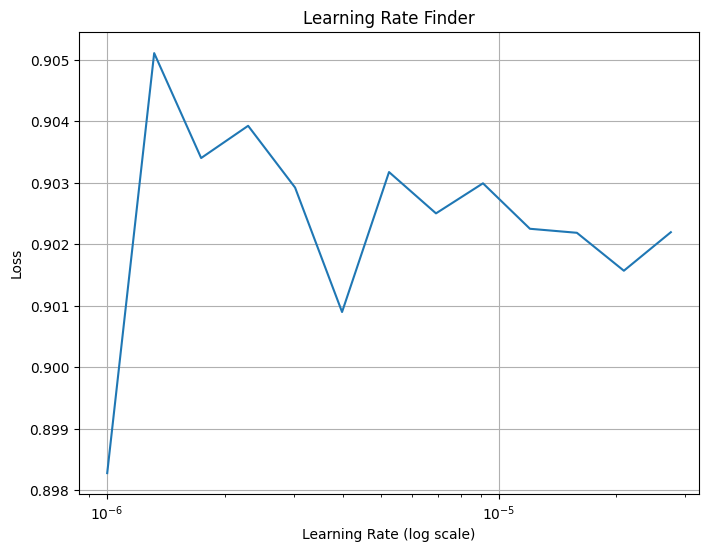

📉 A taxa de aprendizado ideal está na região onde a perda diminui rapidamente, mas ainda não começa a subir.

Treinando Modelo_Base_Blocos...
Epoch 1/25
13/13 - 9s - 719ms/step - accuracy: 0.0463 - loss: 0.8517 - precision_21: 0.0380 - recall_21: 0.6204 - val_accuracy: 0.1250 - val_loss: 0.7286 - val_precision_21: 0.0444 - val_recall_21: 0.7059 - learning_rate: 1.0000e-03
Epoch 2/25
13/13 - 7s - 541ms/step - accuracy: 0.1250 - loss: 0.7777 - precision_21: 0.0512 - recall_21: 0.8108 - val_accuracy: 0.3050 - val_loss: 0.6811 - val_precision_21: 0.0529 - val_recall_21: 0.7353 - learning_rate: 1.0000e-03
Epoch 3/25
13/13 - 10s - 787ms/step - accuracy: 0.2037 - loss: 0.7280 - precision_21: 0.0564 - recall_21: 0.8432 - val_accuracy: 0.3300 - val_loss: 0.6314 - val_precision_21: 0.0629 - val_recall_21: 0.7307 - learning_rate: 1.0000e-03
Epoch 4/25
13/13 - 9s - 697ms/step - accuracy: 0.2288 - loss: 0.6757 - precision_21: 0.0645 - recall_21: 0.8688 - val_accuracy: 0.3100 - val_loss: 0.5995 - va

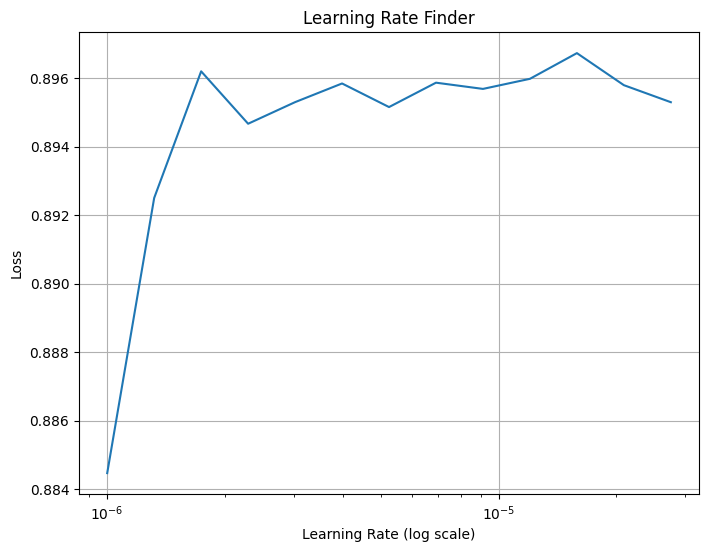

📉 A taxa de aprendizado ideal está na região onde a perda diminui rapidamente, mas ainda não começa a subir.

Treinando Modelo Customizado (Focal Loss) com LR 0.001...

Treinando Modelo_Customizado...
Epoch 1/25
13/13 - 11s - 823ms/step - accuracy: 0.0088 - loss: 0.3070 - precision_23: 0.0336 - recall_23: 0.5544 - val_accuracy: 0.0200 - val_loss: 0.1606 - val_precision_23: 0.0366 - val_recall_23: 0.5557 - learning_rate: 1.0000e-03
Epoch 2/25
13/13 - 10s - 770ms/step - accuracy: 0.0400 - loss: 0.2357 - precision_23: 0.0405 - recall_23: 0.6636 - val_accuracy: 0.2150 - val_loss: 0.1420 - val_precision_23: 0.0453 - val_recall_23: 0.5975 - learning_rate: 1.0000e-03
Epoch 3/25
13/13 - 11s - 815ms/step - accuracy: 0.0700 - loss: 0.1934 - precision_23: 0.0432 - recall_23: 0.6868 - val_accuracy: 0.2200 - val_loss: 0.1172 - val_precision_23: 0.0560 - val_recall_23: 0.6037 - learning_rate: 1.0000e-03
Epoch 4/25
13/13 - 10s - 765ms/step - accuracy: 0.0625 - loss: 0.1643 - precision_23: 0.0455 - re

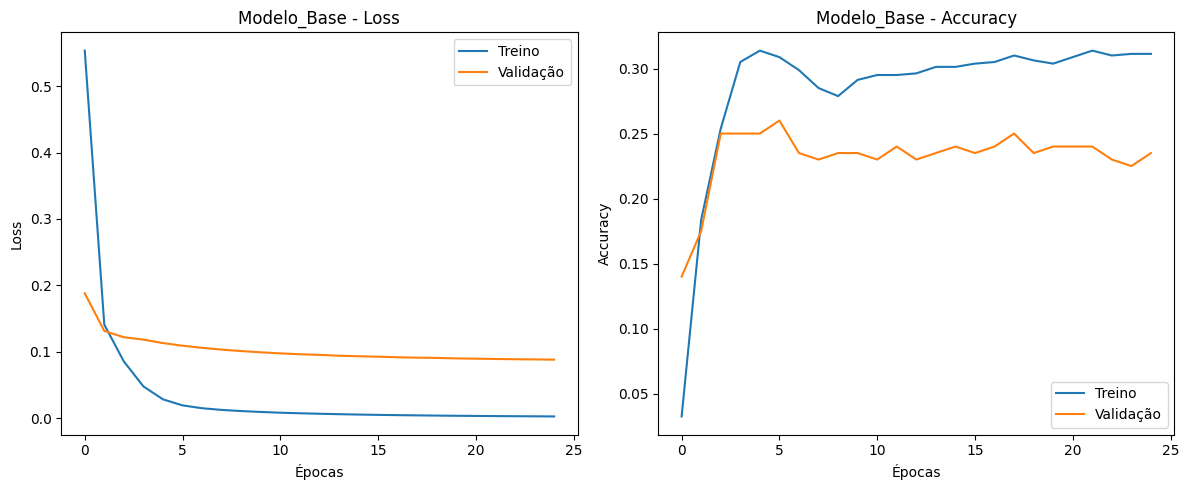

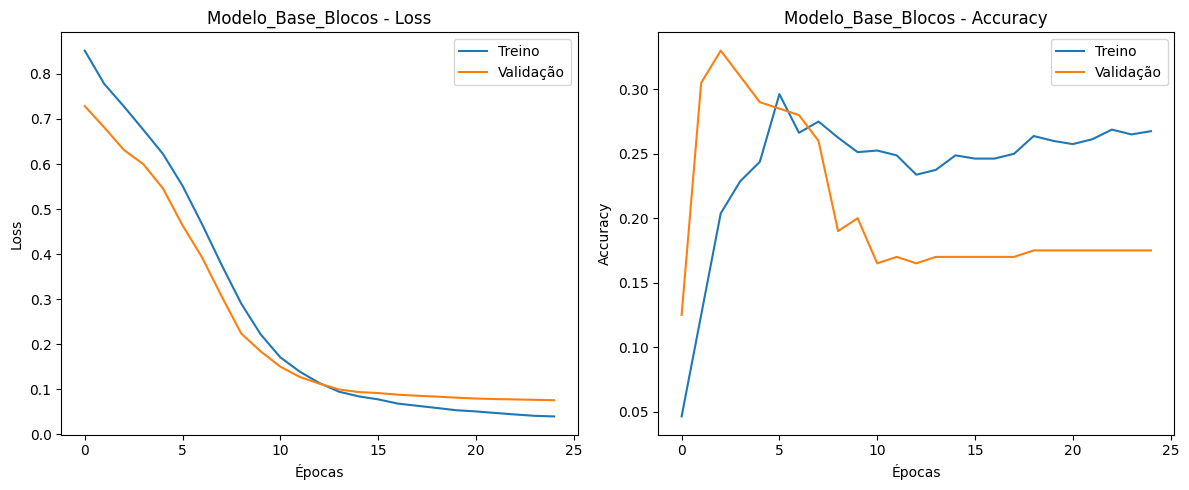

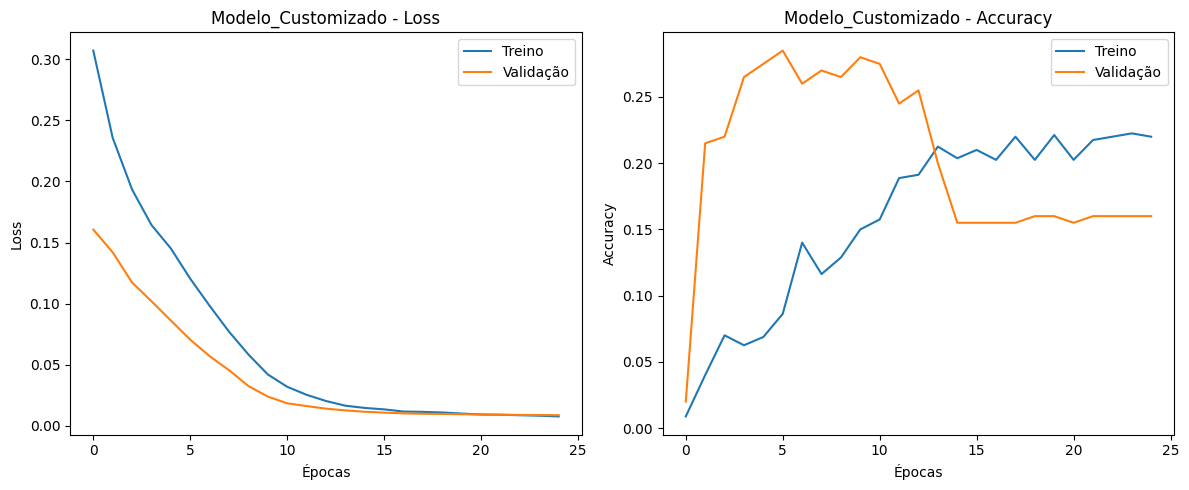

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Matrizes de Confusão - Modelo_Base


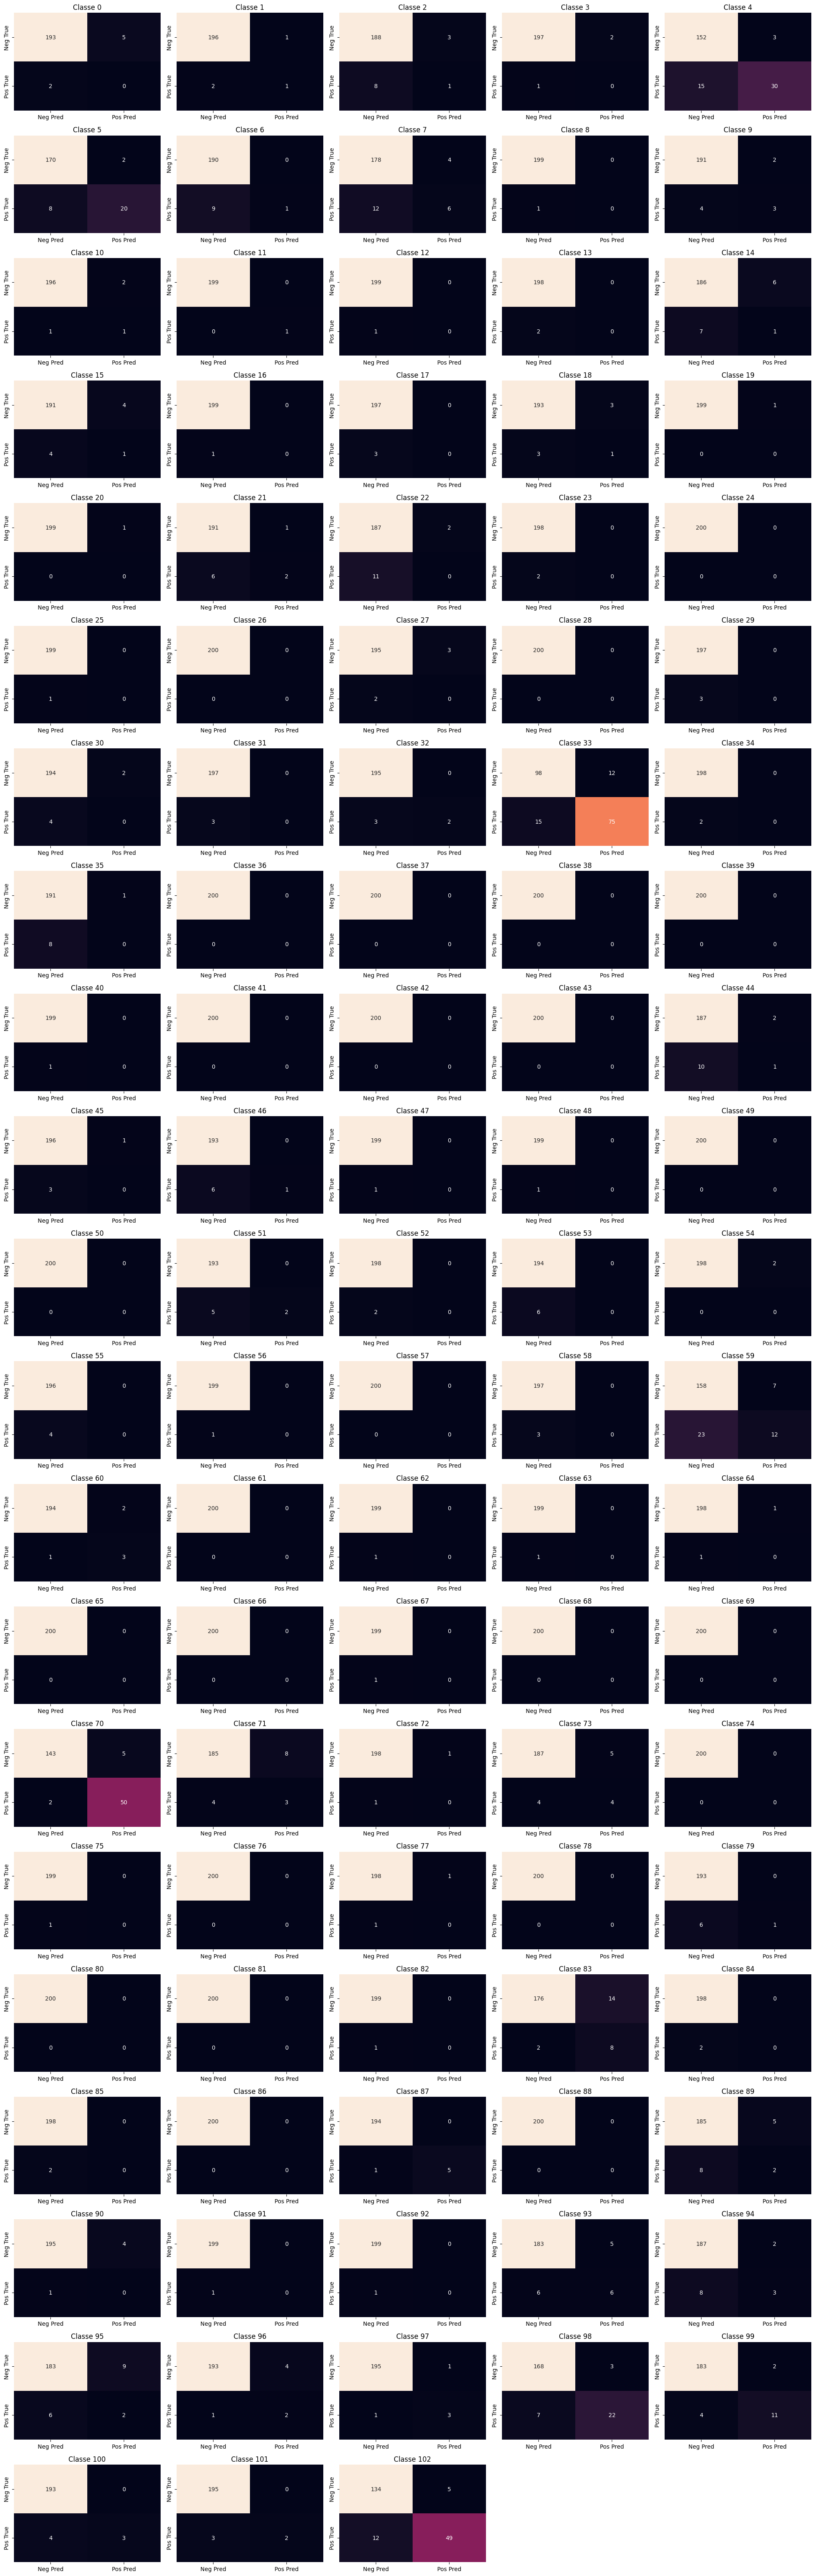

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Matrizes de Confusão - Modelo_Base_Blocos


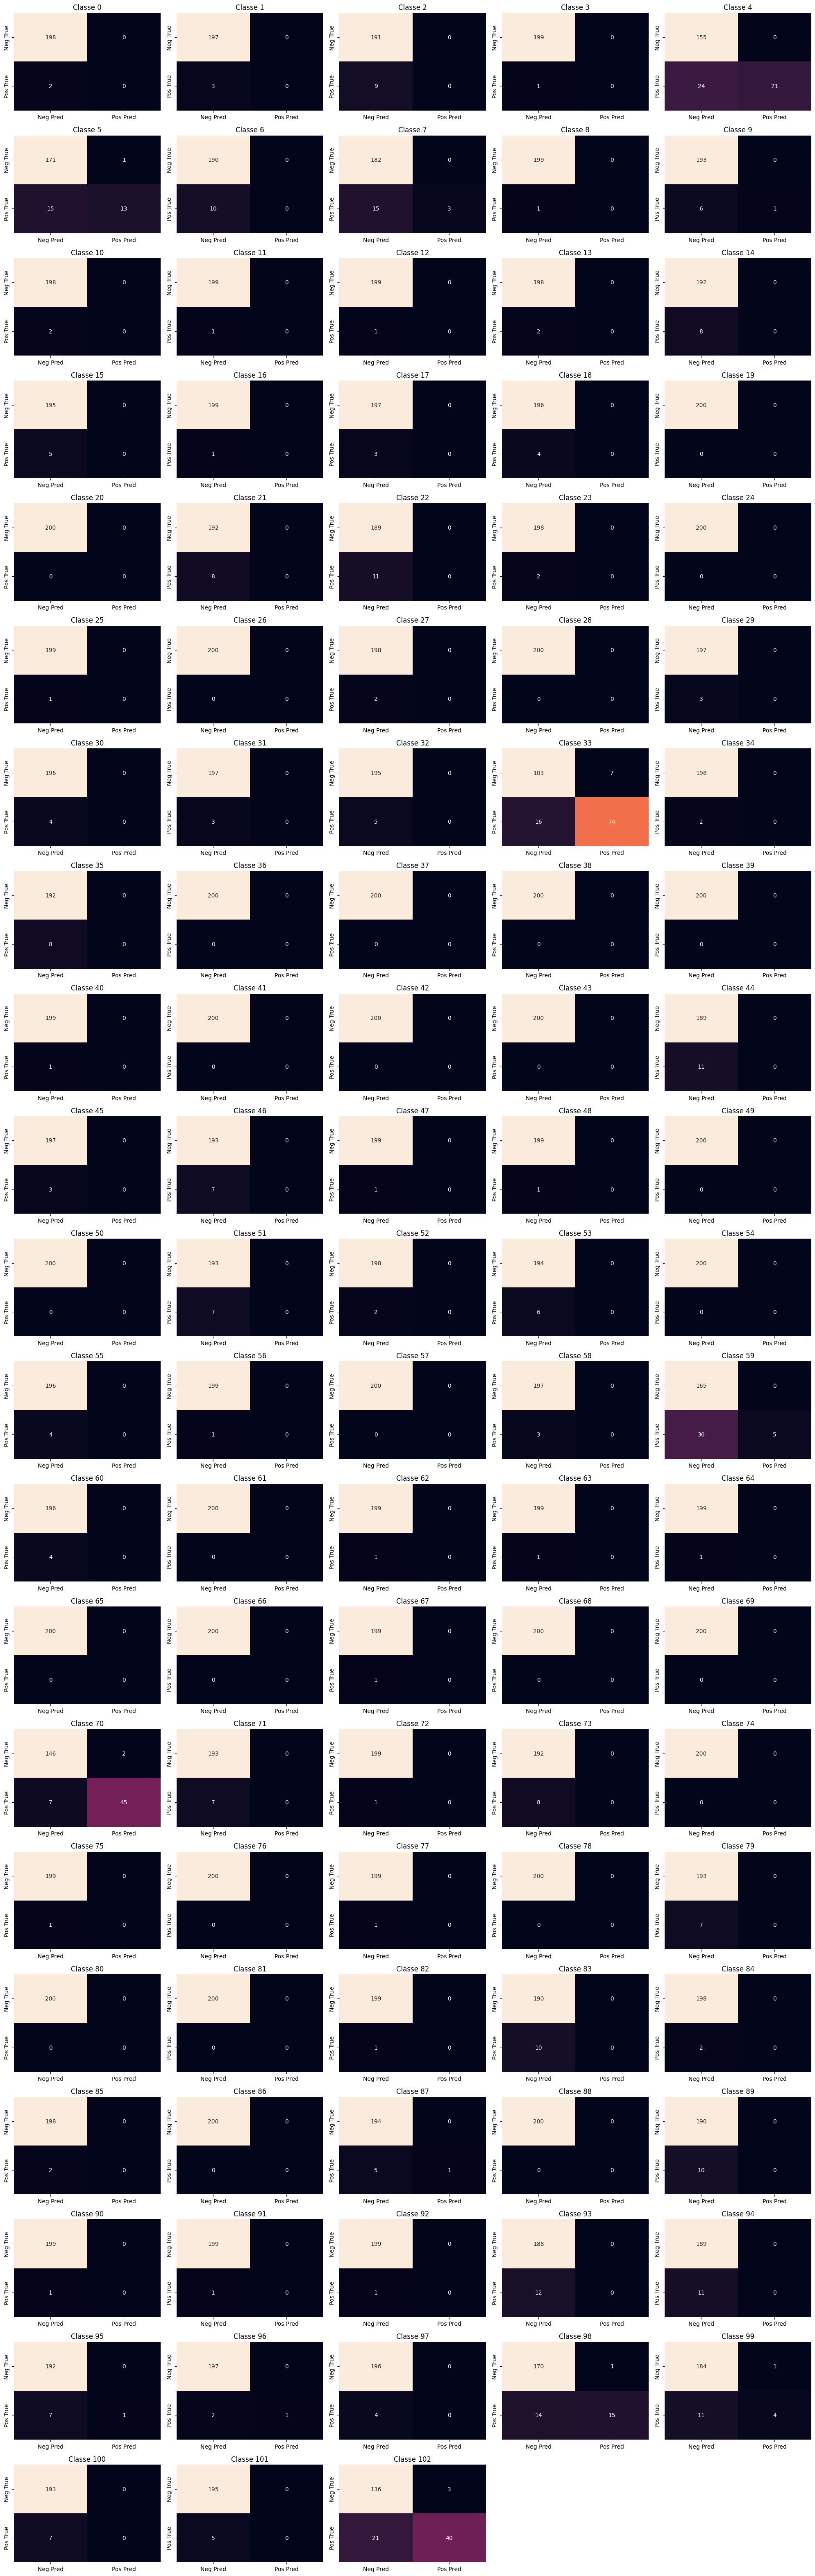

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Matrizes de Confusão - Modelo_Customizado


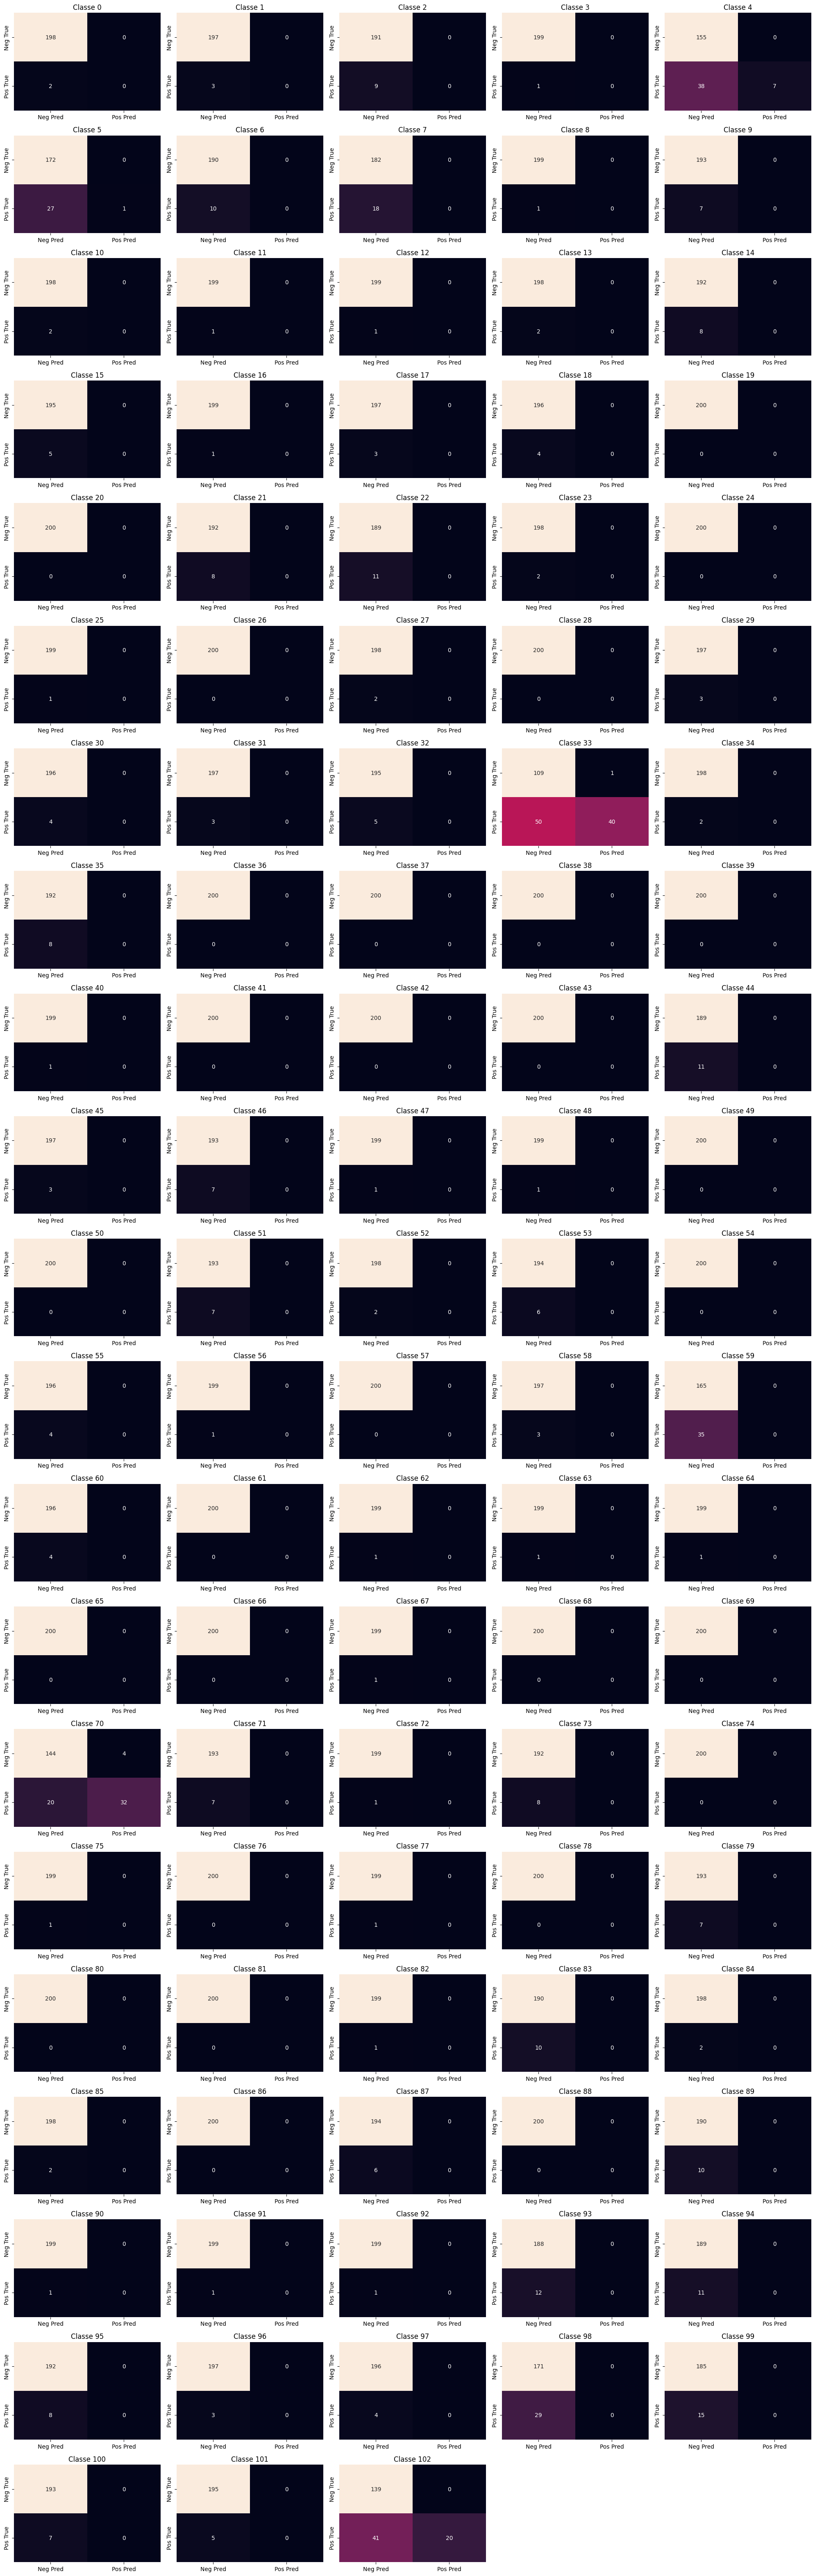

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


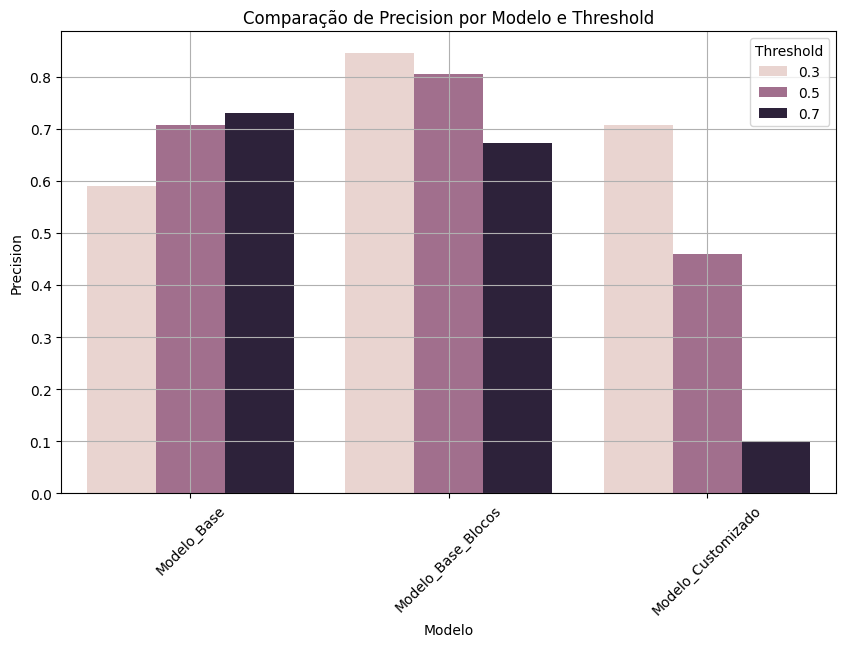

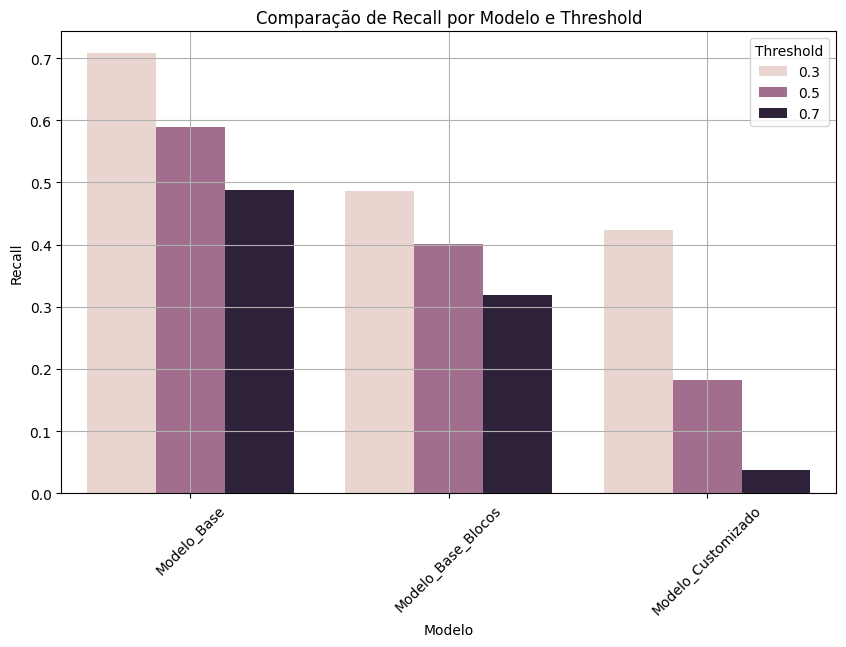

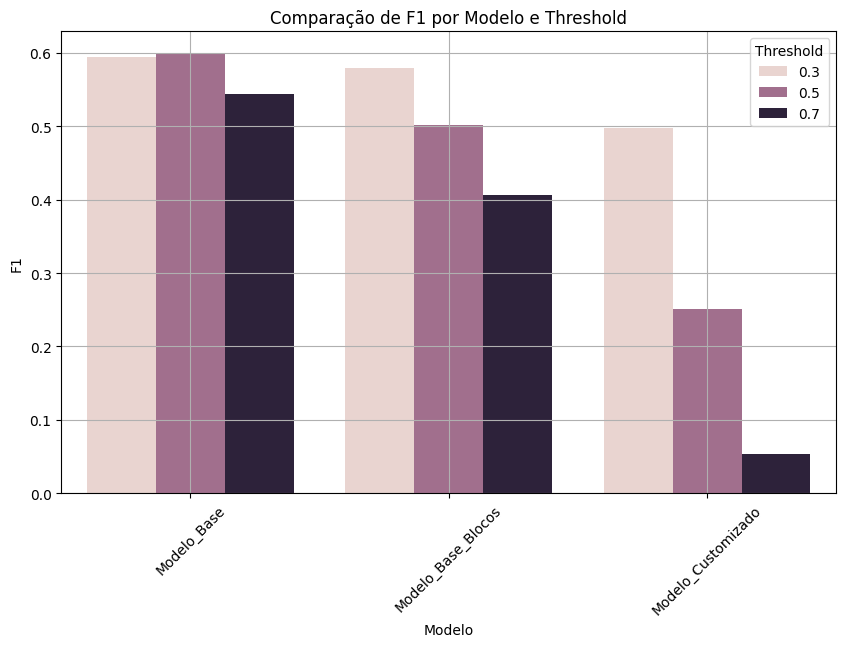

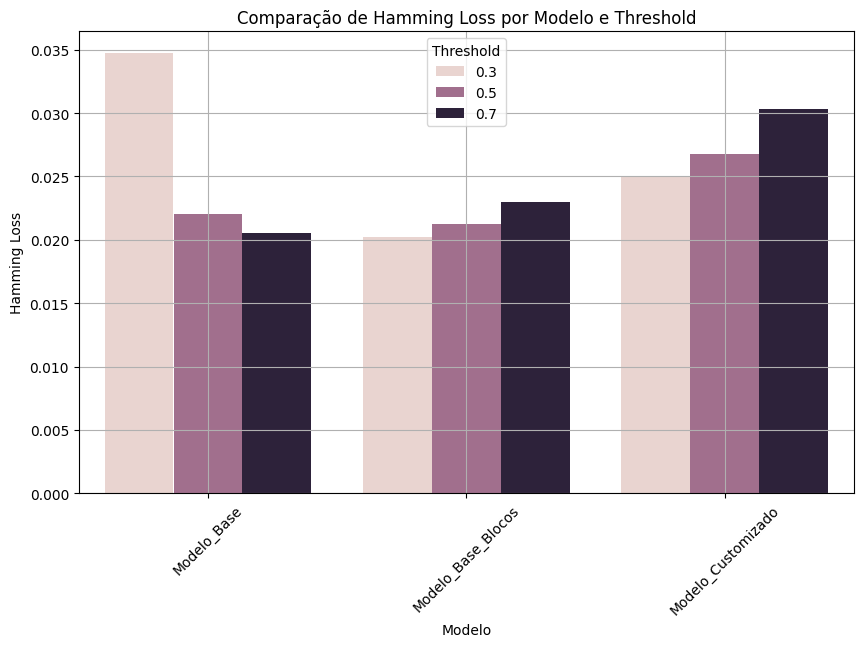

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.datasets import fetch_rcv1
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class LearningRateFinder(tf.keras.callbacks.Callback):
    def __init__(self, start_lr=1e-7, end_lr=10, num_iter=100):
        super().__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_iter = num_iter
        self.lrs = []
        self.losses = []
        self.best_loss = 1e9

    def on_train_begin(self, logs=None):
        self.step = 0
        if not isinstance(self.model.optimizer.learning_rate, tf.Variable):
            self.model.optimizer.learning_rate = tf.Variable(self.start_lr, dtype=tf.float32)
        self.model.optimizer.learning_rate.assign(self.start_lr)

    def on_batch_end(self, batch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        loss = logs["loss"]
        self.lrs.append(lr)
        self.losses.append(loss)
        self.step += 1

        if self.step > self.num_iter or loss > self.best_loss * 10:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        new_lr = lr * (self.end_lr / self.start_lr) ** (1 / self.num_iter)
        self.model.optimizer.learning_rate.assign(new_lr)

    def plot(self):
        plt.figure(figsize=(8,6))
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate (log scale)')
        plt.ylabel('Loss')
        plt.title('Learning Rate Finder')
        plt.grid(True)
        plt.show()

class MultilabelClassificationPipeline:
    def __init__(self, X, Y, test_size=0.2, random_state=42):
        self.X_train_raw, self.X_val_raw, self.Y_train, self.Y_val = train_test_split(
            X, Y, test_size=test_size, random_state=random_state)
        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(self.X_train_raw)
        self.X_val = self.scaler.transform(self.X_val_raw)

        self.num_features = self.X_train.shape[1]
        self.num_classes = self.Y_train.shape[1]

        self.history = {}  # Para salvar os históricos de treino

    def multilabel_metrics(self, y_true, y_pred, threshold=0.5):
        y_pred_bin = (y_pred > threshold).astype(int)
        precision = precision_score(y_true, y_pred_bin, average='samples', zero_division=0)
        recall = recall_score(y_true, y_pred_bin, average='samples', zero_division=0)
        f1 = f1_score(y_true, y_pred_bin, average='samples', zero_division=0)
        hamming = hamming_loss(y_true, y_pred_bin)
        return precision, recall, f1, hamming

    def print_multilabel_confusion(self, y_true, y_pred, threshold=0.5, class_names=None):
        y_pred_bin = (y_pred > threshold).astype(int)
        cm = multilabel_confusion_matrix(y_true, y_pred_bin)
        print("Matriz de Confusão por Classe:")
        for i, matrix in enumerate(cm):
            tn, fp, fn, tp = matrix.ravel()
            cname = f"Classe {i}" if class_names is None else class_names[i]
            print(f"{cname}: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    def build_model_base(self, input_dim, output_dim):
        inputs = layers.Input(shape=(input_dim,))
        x = layers.Dense(512, activation='relu')(inputs)
        outputs = layers.Dense(output_dim, activation='sigmoid')(x)
        model = models.Model(inputs=inputs, outputs=outputs, name="Modelo_Base")
        return model

    def build_model_base_blocos(self, input_dim, output_dim):
        inputs = layers.Input(shape=(input_dim,))
        x = layers.Dense(512, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(256, activation='relu', name='intermediate_layer')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(output_dim, activation='sigmoid')(x)
        model = models.Model(inputs=inputs, outputs=outputs, name="Modelo_Base_Blocos")
        return model

    def build_model_custom(self, input_dim, output_dim):
        def focal_loss(gamma=2., alpha=.25):
            def focal_loss_fixed(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
                cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
                weight = alpha * y_true * tf.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * tf.pow(y_pred, gamma)
                loss = weight * cross_entropy
                return tf.reduce_mean(loss, axis=-1)
            return focal_loss_fixed

        inputs = layers.Input(shape=(input_dim,))
        x = layers.Dense(512, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(256, activation='relu', name='intermediate_layer')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(output_dim, activation='sigmoid')(x)
        model = models.Model(inputs=inputs, outputs=outputs, name="Modelo_Customizado")
        model.compile(optimizer='adam',
                      loss=focal_loss(gamma=2., alpha=0.25),
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        return model

    def find_best_lr(self, model, X_train_data, Y_train_data, epochs=1, batch_size=64):
        print("\nIniciando Learning Rate Finder...")
        lr_finder = LearningRateFinder(start_lr=1e-6, end_lr=1, num_iter=50)
        model.compile(optimizer=optimizers.Adam(learning_rate=lr_finder.start_lr),
                      loss='binary_crossentropy')
        model.fit(X_train_data, Y_train_data,
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[lr_finder],
                  verbose=0)
        lr_finder.plot()
        print("📉 A taxa de aprendizado ideal está na região onde a perda diminui rapidamente, mas ainda não começa a subir.")

    def train(self, model, X_train_data, Y_train_data, X_val_data, Y_val_data, epochs=10, batch_size=64, learning_rate=None):
        print(f"\nTreinando {model.name}...")

        if learning_rate:
            tf.keras.backend.set_value(model.optimizer.learning_rate, learning_rate)
            print(f"Taxa de aprendizado definida para: {learning_rate}")

        callbacks_list = [
            callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
        ]

        history = model.fit(X_train_data, Y_train_data,
                            validation_data=(X_val_data, Y_val_data),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=callbacks_list,
                            verbose=2)
        self.history[model.name] = history
        return history

    def evaluate(self, model, X_val_data, Y_val_data, threshold=0.5):
        y_pred = model.predict(X_val_data)
        return self.multilabel_metrics(Y_val_data, y_pred, threshold), y_pred

    def evaluate_thresholds(self, y_true, y_pred_probs):
        thresholds = np.linspace(0.1, 0.9, 9)
        print("\nAvaliando métricas para diferentes thresholds:")
        for t in thresholds:
            precision = precision_score(y_true, y_pred_probs > t, average='samples', zero_division=0)
            recall = recall_score(y_true, y_pred_probs > t, average='samples', zero_division=0)
            f1 = f1_score(y_true, y_pred_probs > t, average='samples', zero_division=0)
            print(f"Threshold={t:.2f}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

    def demo_hook(self, model, X_val_data):
        print("\nExtraindo saídas intermediárias com hooks (camada densa 256)...")
        if 'intermediate_layer' in [layer.name for layer in model.layers]:
            intermediate_layer_model = models.Model(inputs=model.input,
                                                    outputs=model.get_layer('intermediate_layer').output)
            intermediate_output = intermediate_layer_model.predict(X_val_data[:5])
            print(f"Saída intermediária shape: {intermediate_output.shape}")
        else:
            print("Camada 'intermediate_layer' não encontrada neste modelo.")

    # Métodos de visualização integrados:

    def plot_loss_accuracy(self):

        for model_name, data in self.history.items():
            history = data['history']

            plt.figure(figsize=(12,5))

            # Loss
            plt.subplot(1,2,1)
            plt.plot(history.history['loss'], label='Treino')
            plt.plot(history.history['val_loss'], label='Validação')
            plt.title(f'{model_name} - Loss')
            plt.xlabel('Épocas')
            plt.ylabel('Loss')
            plt.legend()

            # Accuracy
            plt.subplot(1,2,2)
            plt.plot(history.history.get('accuracy', []), label='Treino')
            plt.plot(history.history.get('val_accuracy', []), label='Validação')
            plt.title(f'{model_name} - Accuracy')
            plt.xlabel('Épocas')
            plt.ylabel('Accuracy')
            plt.legend()

            plt.tight_layout()
            plt.show()

    def plot_confusion_matrices(self, threshold=0.5, class_names=None):
        for model_name, data in self.history.items():
            model = data['model']
            X_val = data['X_val']
            Y_val = data['Y_val']

            y_pred = model.predict(X_val)
            y_pred_bin = (y_pred > threshold).astype(int)
            cms = multilabel_confusion_matrix(Y_val, y_pred_bin)
            n_classes = cms.shape[0]

            print(f"\nMatrizes de Confusão - {model_name}")

            fig, axes = plt.subplots(nrows=int(np.ceil(n_classes/5)), ncols=5,
                                    figsize=(20, 3*int(np.ceil(n_classes/5))))
            axes = axes.flatten()

            for i in range(n_classes):
                cm = cms[i]
                sns.heatmap(cm, annot=True, fmt='d', cbar=False, ax=axes[i],
                            xticklabels=['Neg Pred', 'Pos Pred'], yticklabels=['Neg True', 'Pos True'])
                cname = f'Classe {i}' if class_names is None else class_names[i]
                axes[i].set_title(cname)

            for j in range(n_classes, len(axes)):
                fig.delaxes(axes[j])
            plt.tight_layout()
            plt.show()

    def compare_metrics(self, thresholds=[0.5]):
        metrics_data = []

        for model_name, data in self.history.items():
            model = data['model']
            X_val = data['X_val']
            Y_val = data['Y_val']
            y_pred = model.predict(X_val)
            for t in thresholds:
                precision = precision_score(Y_val, y_pred > t, average='samples', zero_division=0)
                recall = recall_score(Y_val, y_pred > t, average='samples', zero_division=0)
                f1 = f1_score(Y_val, y_pred > t, average='samples', zero_division=0)
                hamming = hamming_loss(Y_val, y_pred > t)
                metrics_data.append({
                    'Modelo': model_name,
                    'Threshold': t,
                    'Precision': precision,
                    'Recall': recall,
                    'F1': f1,
                    'Hamming Loss': hamming
                })

        df = pd.DataFrame(metrics_data)

        for metric in ['Precision', 'Recall', 'F1', 'Hamming Loss']:
            plt.figure(figsize=(10,6))
            sns.barplot(data=df, x='Modelo', y=metric, hue='Threshold')
            plt.title(f'Comparação de {metric} por Modelo e Threshold')
            plt.ylabel(metric)
            plt.xlabel('Modelo')
            plt.xticks(rotation=45)
            plt.legend(title='Threshold')
            plt.grid(True)
            plt.show()

    def run_all(self):
        print("Rodando pipeline completa")

        # --- Modelo Base ---
        model_base = self.build_model_base(self.num_features, self.num_classes)
        model_base.compile(optimizer='adam', loss='binary_crossentropy',
                           metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        self.find_best_lr(model_base, self.X_train, self.Y_train)
        best_lr_for_base = 0.001
        model_base.compile(optimizer=optimizers.Adam(learning_rate=best_lr_for_base),
                           loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        history_base = self.train(model_base, self.X_train, self.Y_train, self.X_val, self.Y_val, epochs=25)
        metrics_base, y_pred_base = self.evaluate(model_base, self.X_val, self.Y_val)
        print(f"Métricas Modelo Base: Precision={metrics_base[0]:.4f}, Recall={metrics_base[1]:.4f}, F1={metrics_base[2]:.4f}, Hamming Loss={metrics_base[3]:.4f}")

        # --- Modelo Base + PCA ---
        print("\nAplicando PCA (com dados já escalados)...")
        pca = PCA(n_components=512)
        X_train_pca = pca.fit_transform(self.X_train)
        X_val_pca = pca.transform(self.X_val)

        model_base_pca = self.build_model_base(512, self.num_classes)
        model_base_pca.compile(optimizer='adam', loss='binary_crossentropy',
                               metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        self.find_best_lr(model_base_pca, X_train_pca, self.Y_train)
        best_lr_for_pca = 0.001
        model_base_pca.compile(optimizer=optimizers.Adam(learning_rate=best_lr_for_pca),
                               loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        history_pca = self.train(model_base_pca, X_train_pca, self.Y_train, X_val_pca, self.Y_val, epochs=25)
        metrics_pca, y_pred_pca = self.evaluate(model_base_pca, X_val_pca, self.Y_val)
        print(f"Métricas Modelo Base + PCA: Precision={metrics_pca[0]:.4f}, Recall={metrics_pca[1]:.4f}, F1={metrics_pca[2]:.4f}, Hamming Loss={metrics_pca[3]:.4f}")

        # --- Modelo Base + Blocos ---
        model_blocos = self.build_model_base_blocos(self.num_features, self.num_classes)
        model_blocos.compile(optimizer='adam', loss='binary_crossentropy',
                            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        self.find_best_lr(model_blocos, self.X_train, self.Y_train)
        best_lr_for_blocos = 0.001
        model_blocos.compile(optimizer=optimizers.Adam(learning_rate=best_lr_for_blocos),
                            loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        history_blocos = self.train(model_blocos, self.X_train, self.Y_train, self.X_val, self.Y_val, epochs=25)
        metrics_blocos, y_pred_blocos = self.evaluate(model_blocos, self.X_val, self.Y_val)
        print(f"Métricas Modelo Base + Blocos: Precision={metrics_blocos[0]:.4f}, Recall={metrics_blocos[1]:.4f}, F1={metrics_blocos[2]:.4f}, Hamming Loss={metrics_blocos[3]:.4f}")

        # --- Modelo Customizado (Focal Loss) ---
        model_custom = self.build_model_custom(self.num_features, self.num_classes)
        print("\nExecutando Learning Rate Finder para Modelo Customizado (Focal Loss)...")
        temp_model_for_lr_finder = self.build_model_base_blocos(self.num_features, self.num_classes)
        temp_model_for_lr_finder.compile(optimizer='adam', loss='binary_crossentropy')
        self.find_best_lr(temp_model_for_lr_finder, self.X_train, self.Y_train)
        best_lr_for_custom = 0.001
        print(f"\nTreinando Modelo Customizado (Focal Loss) com LR {best_lr_for_custom}...")
        model_custom.compile(optimizer=optimizers.Adam(learning_rate=best_lr_for_custom),
                             loss=model_custom.loss,
                             metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        history_custom = self.train(model_custom, self.X_train, self.Y_train, self.X_val, self.Y_val, epochs=25)
        metrics_custom, y_pred_custom = self.evaluate(model_custom, self.X_val, self.Y_val)
        print(f"Métricas Modelo Customizado: Precision={metrics_custom[0]:.4f}, Recall={metrics_custom[1]:.4f}, F1={metrics_custom[2]:.4f}, Hamming Loss={metrics_custom[3]:.4f}")

        self.demo_hook(model_custom, self.X_val)

        # Salva todos os histories no dicionário
        # Após treinar o modelo base:
        self.history[model_base.name] = {'history': history_base, 'model': model_base, 'X_val': self.X_val, 'Y_val': self.Y_val}
        # Após treinar o modelo PCA:
        self.history[model_base_pca.name] = {'history': history_pca, 'model': model_base_pca, 'X_val': X_val_pca, 'Y_val': self.Y_val}
        # Após treinar o modelo blocos:
        self.history[model_blocos.name] = {'history': history_blocos, 'model': model_blocos, 'X_val': self.X_val, 'Y_val': self.Y_val}
        # Após treinar o modelo custom:
        self.history[model_custom.name] = {'history': history_custom, 'model': model_custom, 'X_val': self.X_val, 'Y_val': self.Y_val}

        # Gera as visualizações automaticamente
        self.plot_loss_accuracy()
        self.plot_confusion_matrices()
        self.compare_metrics(thresholds=[0.3, 0.5, 0.7])


if __name__ == "__main__":
    print("Carregando dados RCV1...")
    rcv1 = fetch_rcv1(shuffle=True, download_if_missing=True)
    X = rcv1.data[:1000].toarray().astype(np.float32)
    Y = rcv1.target[:1000].toarray().astype(np.float32)

    pipeline = MultilabelClassificationPipeline(X, Y)
    pipeline.run_all()
